# Two operator - two time correlation function

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import (correlation_2op_2t, destroy, fock_dm, qeye, tensor)

from torchqc.states import QuantumState
from torchqc.operators import Operator
from torchqc.common_functions import get_density_matrix
from torchqc.common_matrices import annihilation, eye
from torchqc.tensor_product import tensor_product_ops
from torchqc.correlation import correlation_fn_2op_2time
import torch

%matplotlib inline

* Two coupled resonators (optomechanical system)

In [2]:
wc = 1.0 * 2 * np.pi  # cavity frequency
wa = 1.0 * 2 * np.pi  # resonator frequency
g = 0.3 * 2 * np.pi  # coupling strength
kappa = 0.075  # cavity dissipation rate
gamma = 0.005  # resonator dissipation rate
Na = Nc = 3  # number of cavity fock states
n_th = 0.0  # avg number of thermal bath excitation

T = 7.5
steps = 251
tlist = np.linspace(0, 7.5, 251)
Dt = T / steps
tlist_sub = tlist[0:int((len(tlist) / 2))]

* QUTIP calculation

In [3]:
# start with an excited resonator
rho0 = tensor(fock_dm(Na, 0), fock_dm(Nc, 1))

a = tensor(qeye(Nc), destroy(Na))
c = tensor(destroy(Nc), qeye(Na))

na = a.dag() * a
nc = c.dag() * c

H = wa * na + wc * nc - g * (a + a.dag()) * (c + c.dag())

# measurement operator on resonator
Q = na  # photon number resolving detector

c_op_list = []

rate = kappa * (1 + n_th)
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * c)

rate = kappa * n_th
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * c.dag())

rate = gamma * (1 + n_th)
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * a)

rate = gamma * n_th
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * a.dag())

In [4]:
corr_mat = correlation_2op_2t(H, rho0, tlist, tlist, c_op_list, Q, Q)

* torchqc calculation

In [5]:
rho0_a = get_density_matrix(QuantumState.basis(Na)[0])
rho0_c = get_density_matrix(QuantumState.basis(Nc)[1])

rho0 = tensor_product_ops(rho0_a, rho0_c)

# Na = Nc
a_a = tensor_product_ops(eye(Nc), annihilation(Na))
a_c = tensor_product_ops(annihilation(Nc), eye(Na))

na_op = a_a.dagger() * a_a
nc_op = a_c.dagger() * a_c

H = wa * na_op + wc * nc_op - g * (a_a + a_a.dagger()) * (a_c + a_c.dagger())

Q = na_op

In [6]:
jump_ops = []
rates = []

rate = kappa * (1 + n_th)
if rate > 0.0:
    jump_ops.append(a_c)
    rates.append(rate)

rate = kappa * n_th
if rate > 0.0:
    jump_ops.append(a_c.dagger())
    rates.append(rate)

rate = gamma * (1 + n_th)
if rate > 0.0:
    jump_ops.append(a_a)
    rates.append(rate)

rate = gamma * n_th
if rate > 0.0:
    jump_ops.append(a_c.dagger())
    rates.append(rate)

In [ ]:
ham_tensor = H.matrix.expand(len(tlist), -1, -1).type(torch.complex128)
hamiltonian = Operator(H.dims, ham_tensor)

corr_torchqc = correlation_fn_2op_2time(hamiltonian, rho0, tlist, tlist, Dt, Q, Q, jump_ops, rates)

* Compare the two correlations

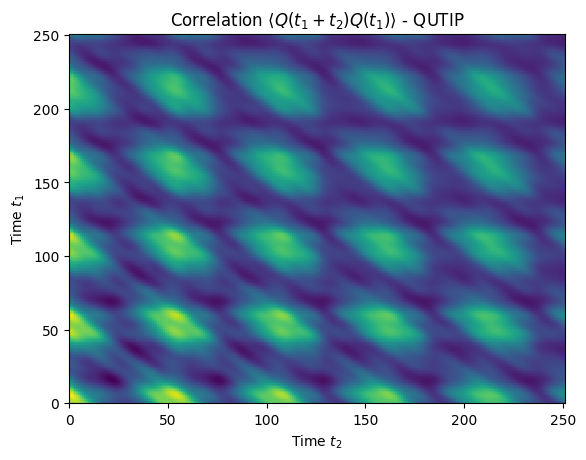

In [ ]:
plt.pcolor(np.real(corr_mat))
plt.xlabel(r'Time $t_2$')
plt.ylabel(r'Time $t_1$')
plt.title(r'Correlation $\left<Q(t_1+t_2)Q(t_1)\right>$ - QUTIP')
plt.show()

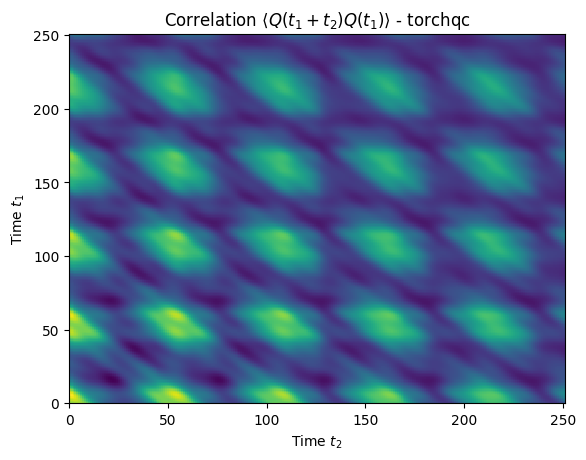

In [ ]:
plt.pcolor(np.real(corr_torchqc))
plt.xlabel(r'Time $t_2$')
plt.ylabel(r'Time $t_1$')
plt.title(r'Correlation $\left<Q(t_1+t_2)Q(t_1)\right>$ - torchqc')
plt.show()